In [1]:
#Path has been added to include the permutation functions
import sys
import os
sys.path.append(os.path.join(os.getcwd() , ".." , "Python_scripts"))

In [2]:
#libraries
import scanpy as sc
import pandas as pd
import numpy as np
import copy
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt
import random
from permutation import freq_to_link_table , calculate_statistic , run_permutation_parallel
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import pdist
from pySankey.sankey import sankey
import plotly.graph_objects as go
from pandas.api.types import CategoricalDtype
from plotnine import *

In [3]:
#Set seed
seed_number = 42

random.seed(seed_number)     # python random generator
np.random.seed(seed_number)  # numpy random generator

In [4]:
#Function to get a range of colours
def get_distinct_colors_rgba(n):
    cmap = plt.get_cmap('tab10') if n <= 9 else plt.get_cmap('Paired')
    colors = [cmap(i / n) for i in range(n)]
    
    # Scale to [0, 180] and convert to integer RGBA
    scaled_colors = [
        tuple(int(channel * 180) for channel in color[:3]) + (0.8,)  # Set alpha = 180
        for color in colors
    ]
    
    scaled_colors_string = ["rgba" + str(scaled_col) for scaled_col in scaled_colors]
    
    return scaled_colors_string

In [5]:
#All the neuron types included in the analysis
neuron_types = ["dI1","dI2","dI3","dI4_dILA" , "dI5_dILB"  , "dI6" , "V0" , "V1", "V2" , "MN"]

#neuron_types = ["dI6" , "V0" , "V1", "V2" , "MN"]

#Read in meta data
chicken_meta_all = pd.read_csv(os.path.join(os.getcwd() , ".." , "metadata" , "larry_chicken.csv"))

#Only select meta data for which cells have been assigned a wave
chicken_meta = chicken_meta_all[~((chicken_meta_all["wave"].isna()) | (chicken_meta_all["wave"].isin(["unknown","neg","multiple_pos"])))].copy()

#For the wave analysis V2a and V2b is taken together
chicken_meta["cell_type_V2"] = ["V2" if el in ["V2a","V2b"] else el  for el in chicken_meta["cell_type"]]

#Only select entries from the selected neuron types
chicken_meta = chicken_meta[chicken_meta["cell_type_V2"].isin(neuron_types)]

In [6]:
import re
#Add sample time point
chicken_meta["time"] = [40 if re.match("A[1-4]$"  , clone.split("BOE5073")[1]) else 55 if (re.match("A1[3-9]$"  , clone.split("BOE5073")[1]) or re.match("A20$"  , clone.split("BOE5073")[1])) else 70 for clone in chicken_meta["sample"]]

In [7]:
#Calculate the amount per wave per celltype
cell_type_fractions = chicken_meta.groupby(["cell_type_V2" , "time" , "wave"]).size().reset_index(name = "total")

In [8]:
#Calculate cell fractions across waves
def cell_type_fractions(chicken_meta):
    #Calculate the amount per wave per celltype
    cell_type_fractions = chicken_meta.groupby(["cell_type_V2" , "wave"]).size().reset_index(name = "total")

    #Calculte the total amount of cells for every cell type
    total_cell = cell_type_fractions.groupby("cell_type_V2")["total"].transform(sum)

    #Add total amount of cell types to the dataframe
    cell_type_fractions["total_type"] = total_cell.copy()

    #Calculate the relative amount of cell types
    cell_type_fractions["rel_amount"] = cell_type_fractions["total"]/cell_type_fractions["total_type"]

    #Make wave variable categorical: important for the order of plotting
    cell_type_fractions['wave'] = pd.Categorical(cell_type_fractions['wave'], categories=['late', 'mid', 'early'], ordered=True)
    cell_type_fractions['cell_type_V2'] = pd.Categorical(cell_type_fractions['cell_type_V2'], categories=neuron_types, ordered=True)
    
    return cell_type_fractions

In [9]:
#Calculate fraction
chicken_fraction_plot = cell_type_fractions(chicken_meta)

#Add column to say that all neuron were included
chicken_fraction_plot["database"] = "all_cells"

/var/folders/n1/_w5w96rd4db43g5pls6zz29r0000gp/T/ipykernel_26290/400605664.py:7: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


In [10]:
###For later
chicken_meta_clone = chicken_meta[~chicken_meta["clone"].isna()]

In [11]:
#Calculate fraction
chicken_fraction_clone_plot = cell_type_fractions(chicken_meta_clone)

#Add column to say that all neuron were included
chicken_fraction_clone_plot["database"] = "clone_cells"

/var/folders/n1/_w5w96rd4db43g5pls6zz29r0000gp/T/ipykernel_26290/400605664.py:7: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


In [12]:
#Concatenate both datasets
chicken_wave_plot = pd.concat([chicken_fraction_plot , chicken_fraction_clone_plot])

In [13]:
# Create stacked bar plot of the wave fraction
plot = (
    ggplot(chicken_wave_plot, aes(x='cell_type_V2', y='rel_amount', fill='wave')) +
    geom_bar(stat='identity') +
    theme_minimal() +
    labs(title='Stacked Bar Plot', y='Value', x='Category') +
    facet_wrap('~database') +
    theme(axis_text_x=element_text(rotation=90, hjust=1))
)

print(plot)

<ggplot: (640 x 480)>


In [14]:
#Cell types of interest
#Chicken
neurons_waves = [celltype + "_" + wave for celltype in neuron_types for wave in ["early","mid","late"] ]

#Order of plotting
plot_order_early = [neur for neur in neurons_waves if neur.endswith("early")]
plot_order_mid = [neur for neur in neurons_waves if neur.endswith("mid")]
plot_order_late = [neur for neur in neurons_waves if neur.endswith("late")]

#Add cell_type_wave to the meta data
chicken_meta_clone["cell_type_wave"] = chicken_meta_clone["cell_type_V2"] + "_" + chicken_meta_clone["wave"]

/var/folders/n1/_w5w96rd4db43g5pls6zz29r0000gp/T/ipykernel_26290/135752151.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [15]:
#Get amount of cells per clone/Cell type combination
clone_celltype_combo = chicken_meta_clone.groupby(["clone" , "cell_type_wave"]).size().reset_index(name = "amount")

#Reshape data
clone_celltype_combo_wide = clone_celltype_combo.pivot(index = "clone" , columns="cell_type_wave" , values = "amount").fillna(0).astype("int")

#Complete column with cell types that have no connections
absent_cell_types = np.array(neurons_waves)[~np.isin(neurons_waves , clone_celltype_combo_wide.columns)]

for absent_cell in absent_cell_types:
    clone_celltype_combo_wide[absent_cell] = 0

In [16]:
import os
import matplotlib.pyplot as plt

def save_plot(plot_name):
    # Define fixed directory
    plot_dir = os.path.join("plots", "waves")
    os.makedirs(plot_dir, exist_ok=True)

    # Full path
    save_path = os.path.join(plot_dir, f"{plot_name}.pdf")

    # Save active figure
    plt.savefig(save_path, format='pdf', bbox_inches='tight')
    print(f"✅ Plot saved to {save_path}")


## Jaccard similarity

In [17]:
#Dictionay with celltypes as keys and clone names as values
celltype_clones = {celltype : set(clone_celltype_combo_wide[clone_celltype_combo_wide[celltype] > 0].index) for celltype in clone_celltype_combo_wide.columns}

In [18]:
# Initialize an empty DataFrame
jaccard_matrix = pd.DataFrame(index=neurons_waves, columns=neurons_waves, dtype=float)

# Initialize an empty DataFrame
clones_shared = pd.DataFrame(index=neurons_waves, columns=neurons_waves, dtype=float)

# Fill in the Jaccard similarity
for k1 in neurons_waves:
    for k2 in neurons_waves:
        
        clones_shared.loc[k1, k2] = clone_celltype_combo_wide[(clone_celltype_combo_wide[k1] > 0) & (clone_celltype_combo_wide[k2] > 0)].shape[0]
        
        if k1 == k2:
            jaccard_matrix.loc[k1, k2] = 0
        else:
            intersection = len(celltype_clones[k1] & celltype_clones[k2])
            union = len(celltype_clones[k1] | celltype_clones[k2])
            jaccard = intersection / union if union > 0 else 0
            jaccard_matrix.loc[k1, k2] = np.log(jaccard * 100 + 1e-20)

✅ Plot saved to plots/waves/jaccard_waves_all.pdf


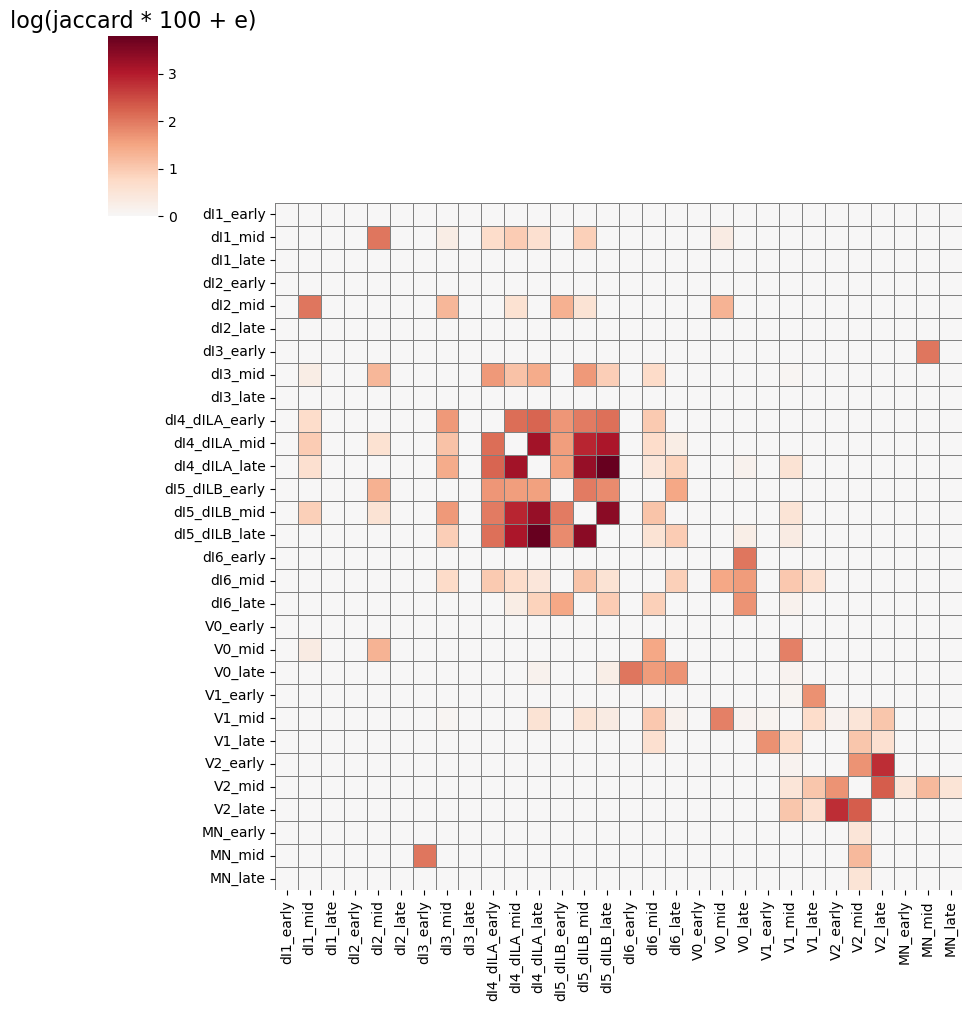

<Figure size 640x480 with 0 Axes>

In [19]:
#Fill the NA values
X = jaccard_matrix.loc[neurons_waves,neurons_waves]

# Overlay heatmap for significant values with higher alpha
g = sns.clustermap(
    X,
    cmap='RdBu_r',
    vmin=0,
    center=0,
    row_cluster=False,
    col_cluster=False,
    linewidths=0.5,
    linecolor='grey',
    figsize=(10, 10),
    method = "ward"
)

title_text = "log(jaccard * 100 + e)"

# Move y-axis (row) labels to the left
g.ax_heatmap.yaxis.tick_left()
g.ax_heatmap.yaxis.set_label_position("left")

# Set the title
plt.title(title_text, fontsize=16)

save_plot("jaccard_waves_all")

plt.show()
plt.clf()

## Sankey diagram: based on Jaccard similarity

In [20]:
#Make dataset for the weight of the cell types connections: Jaccard similarity

#Dictionary with MID cell type, LATE cell type and connection weight
connection_data = {"MID" : [] , "LATE" : [] , "WEIGHT" : []}

#Loop over all the MID cell types
for mid_type in plot_order_mid:
    #Loop over all the LATE cell types
    for late_type in plot_order_late:
        #Take jaccard similarity (previously calculated)
        value = jaccard_matrix.loc[mid_type,late_type]
        #Remove negative values (Jaccard values are log transformed)
        if value < 0:
            value = 0
        
        #Add data to dictionary
        connection_data["MID"].append(mid_type)
        connection_data["LATE"].append(late_type)
        connection_data["WEIGHT"].append(10 * value)

In [21]:
#Make dataframe from dictionary
df = pd.DataFrame(connection_data)
df["MID_CLEAN"] = ["_".join(el.split("_")[:-1]) for el in df["MID"]]
df["LATE_CLEAN"] = ["_".join(el.split("_")[:-1]) for el in df["LATE"]]

#More than one cell per clone
link_db = df.query("WEIGHT > 0").copy()

In [22]:
#link database to determine the link layout of the Sankey plot
#Make dictionary that assigns cell types to an index
cell_types = plot_order_mid + plot_order_late
cell_type_positions = {cell_type : number for number, cell_type in enumerate(np.array(cell_types)[np.isin(cell_types, pd.concat([link_db["MID"], link_db["LATE"]]).unique())])}

#Add index to link_db
link_db["MID_index"] = [cell_type_positions[cell_type] for cell_type in link_db["MID"]]
link_db["LATE_index"] = [cell_type_positions[cell_type] for cell_type in link_db["LATE"]]

#Add colour to lind_db
celltype_color_dict = {name : color for name, color in zip(neuron_types , get_distinct_colors_rgba(len(neuron_types)))}
link_db["link_color"] = [celltype_color_dict[cell_type] for cell_type in link_db["MID_CLEAN"]]

In [23]:
#node database to determine the node layout of the Sankey plot

#Distance between nodes:
#Cell type categories
cat_type = CategoricalDtype(categories=neuron_types, ordered=True)
#mid
sep_weight_mid = link_db.groupby("MID_CLEAN")["WEIGHT"].sum().reset_index(name = "weight")
sep_weight_mid.columns = ["celltype" , "weight"]
# Apply to the column
sep_weight_mid['celltype'] = sep_weight_mid['celltype'].astype(cat_type)
# Sort by the custom order
sep_weight_mid = sep_weight_mid.sort_values('celltype')

#late
sep_weight_late = link_db.groupby("LATE_CLEAN")["WEIGHT"].sum().reset_index(name = "weight")
sep_weight_late.columns = ["celltype" , "weight"]
# Apply to the column
sep_weight_late['celltype'] = sep_weight_late['celltype'].astype(cat_type)
# Sort by the custom order
sep_weight_late = sep_weight_late.sort_values('celltype')

#Get maximum weight MID vs LATE
sep_weight = pd.concat([sep_weight_mid , sep_weight_late]).groupby("celltype", observed=True)["weight"].max().reset_index()
sep_weight.at[0,"weight"] = 50
sep_weight["cum_weights"] = sep_weight['weight'].cumsum()

sep_weight_dict = {celltype : weight for celltype , weight in zip(sep_weight["celltype"] , sep_weight["cum_weights"])}

In [24]:
#Select mid wave data
mid_data = link_db[["MID" , "MID_index"]].drop_duplicates()
mid_data["x"] = [0.1 for el in range(mid_data.shape[0])]
mid_data["y"] = [(number * 0.15) + (0.001 * sep_weight_dict[celltype[:-4]]) for number ,celltype in enumerate(plot_order_mid) if celltype in set(mid_data["MID"])]

mid_data.columns = ["cell_type" , "index" , "x" , "y"]

#Select late wave data
late_data = link_db[["LATE" , "LATE_index"]].drop_duplicates()
late_data["x"] = [0.9 for el in range(late_data.shape[0])]
y_pos_dict = {celltype : (number * 0.15) + (0.001 * sep_weight_dict[celltype[:-5]]) for number , celltype in enumerate(plot_order_late) if celltype in set(late_data["LATE"])}

late_data["y"] = [y_pos_dict[celltype] for celltype in late_data["LATE"]]

late_data.columns = ["cell_type" , "index" , "x" , "y"]

#Concatenate data
node_db = pd.concat([mid_data , late_data])

node_db["cell_type"] = ["_".join(celltype.split("_")[:-1]) for celltype in node_db["cell_type"]]

#Colour
node_db["colour"] = [celltype_color_dict[cell_type] for cell_type in node_db["cell_type"]]

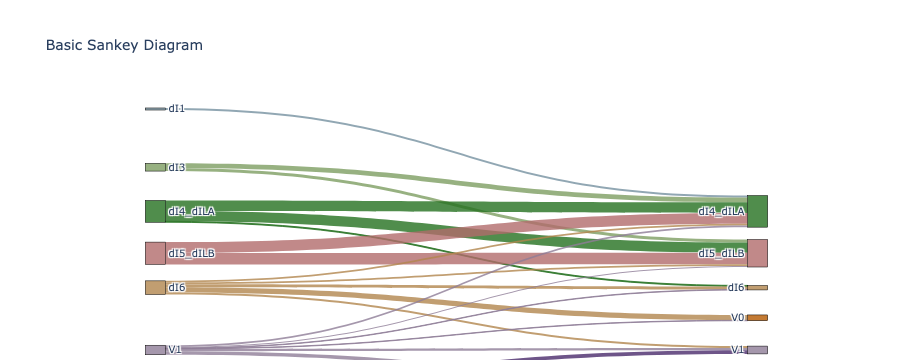

In [25]:
#Create Sankey figure
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = node_db["cell_type"],
      color = node_db["colour"],
        x = node_db["x"],
        y = node_db["y"]
    ),
    link = dict(
      source = link_db["MID_index"], 
      target = link_db["LATE_index"],
      value = link_db["WEIGHT"],
        color = link_db["link_color"]
  ))])

fig.update_layout(title_text="Basic Sankey Diagram", font_size=10)

fig.show()
#fig.write_image(os.path.join(os.getcwd() , ".." , "data","figures" , "sankey_diagram_jaccard.pdf"))

## Sankey diagram: based on connections

In [26]:
#Only clones with a minimum size of 2
clone_celltype_combo_wide_min2 = clone_celltype_combo_wide[np.sum(clone_celltype_combo_wide, axis = 1) > 1]

In [27]:
connection_data = {"MID" : [] , "LATE" : [] , "WEIGHT" : []}

for mid_type in plot_order_mid:
    for late_type in plot_order_late:
        mid_late_combo = clone_celltype_combo_wide_min2[[mid_type,late_type]]
        mid_late_combo.columns = ["MID" , "LATE"]
        mid_late_combo_both_present = mid_late_combo.query("MID > 0 & LATE > 0")
        mid_late_combo_both_present_value = mid_late_combo_both_present.shape[0]
        
        #Add data to dictionary
        connection_data["MID"].append(mid_type)
        connection_data["LATE"].append(late_type)
        connection_data["WEIGHT"].append(mid_late_combo_both_present_value)

In [28]:
#Make dataframe from dictionary
df = pd.DataFrame(connection_data)
df["MID_CLEAN"] = ["_".join(el.split("_")[:-1]) for el in df["MID"]]
df["LATE_CLEAN"] = ["_".join(el.split("_")[:-1]) for el in df["LATE"]]

#More than one cell per clone
link_db = df.query("WEIGHT > 0").copy()

In [29]:
#link database to determine the link layout of the Sankey plot
#Make dictionary that assigns cell types to an index
cell_types = plot_order_mid + plot_order_late
valid_types = pd.concat([link_db["MID"], link_db["LATE"]]).unique()

cell_type_positions = {
    cell_type: number
    for number, cell_type in enumerate(np.array(cell_types)[np.isin(cell_types, valid_types)])
}


#Add index to link_db
link_db["MID_index"] = [cell_type_positions[cell_type] for cell_type in link_db["MID"]]
link_db["LATE_index"] = [cell_type_positions[cell_type] for cell_type in link_db["LATE"]]

#Add colour to lind_db
celltype_color_dict = {name : color for name, color in zip(neuron_types , get_distinct_colors_rgba(len(neuron_types)))}
link_db["link_color"] = [celltype_color_dict[cell_type] for cell_type in link_db["MID_CLEAN"]]

In [30]:
#node database to determine the node layout of the Sankey plot

#Distance between nodes:
#Cell type categories
cat_type = CategoricalDtype(categories=neuron_types, ordered=True)
#mid
sep_weight_mid = link_db.groupby("MID_CLEAN")["WEIGHT"].sum().reset_index(name = "weight")
sep_weight_mid.columns = ["celltype" , "weight"]
# Apply to the column
sep_weight_mid['celltype'] = sep_weight_mid['celltype'].astype(cat_type)
# Sort by the custom order
sep_weight_mid = sep_weight_mid.sort_values('celltype')

#late
sep_weight_late = link_db.groupby("LATE_CLEAN")["WEIGHT"].sum().reset_index(name = "weight")
sep_weight_late.columns = ["celltype" , "weight"]
# Apply to the column
sep_weight_late['celltype'] = sep_weight_late['celltype'].astype(cat_type)
# Sort by the custom order
sep_weight_late = sep_weight_late.sort_values('celltype')

#Get maximum weight MID vs LATE
sep_weight = pd.concat([sep_weight_mid , sep_weight_late]).groupby("celltype", observed=True)["weight"].max().reset_index()
sep_weight.at[0,"weight"] = 50
sep_weight["cum_weights"] = sep_weight['weight'].cumsum()

sep_weight_dict = {celltype : weight for celltype , weight in zip(sep_weight["celltype"] , sep_weight["cum_weights"])}

In [31]:
#Select mid wave data
mid_data = link_db[["MID" , "MID_index"]].drop_duplicates()
mid_data["x"] = [0.1 for el in range(mid_data.shape[0])]
mid_data["y"] = [(number * 0.15) + (0.001 * sep_weight_dict[celltype[:-4]]) for number ,celltype in enumerate(plot_order_mid) if celltype in set(mid_data["MID"])]

mid_data.columns = ["cell_type" , "index" , "x" , "y"]

#Select late wave data
late_data = link_db[["LATE" , "LATE_index"]].drop_duplicates()
late_data["x"] = [0.9 for el in range(late_data.shape[0])]
y_pos_dict = {celltype : (number * 0.15) + (0.001 * sep_weight_dict[celltype[:-5]]) for number , celltype in enumerate(plot_order_late) if celltype in set(late_data["LATE"])}

late_data["y"] = [y_pos_dict[celltype] for celltype in late_data["LATE"]]

late_data.columns = ["cell_type" , "index" , "x" , "y"]

#Concatenate data
node_db = pd.concat([mid_data , late_data])

node_db["cell_type"] = ["_".join(celltype.split("_")[:-1]) for celltype in node_db["cell_type"]]

#Colour
node_db["colour"] = [celltype_color_dict[cell_type] for cell_type in node_db["cell_type"]]

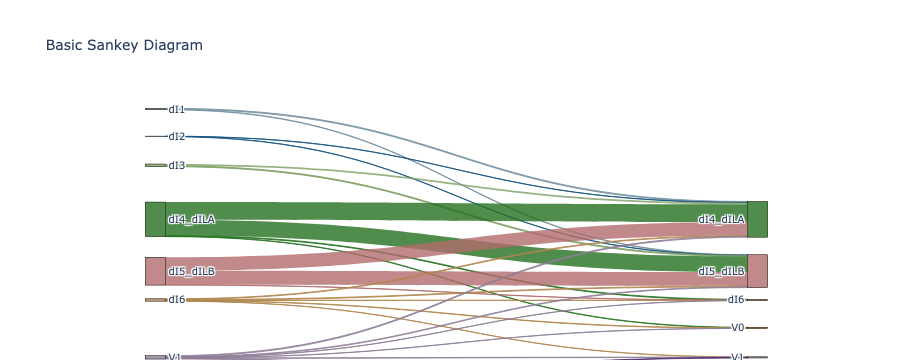

In [32]:
#Create Sankey figure
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = node_db["cell_type"],
      color = node_db["colour"],
        x = node_db["x"],
        y = node_db["y"]
    ),
    link = dict(
      source = link_db["MID_index"], 
      target = link_db["LATE_index"],
      value = link_db["WEIGHT"],
        color = link_db["link_color"]
  ))])

fig.update_layout(title_text="Basic Sankey Diagram", font_size=10)

fig.show()
#fig.write_image(os.path.join(os.getcwd() , ".." , "data","figures" , "sankey_diagram_connections.pdf"))

## Permutation test

In [33]:
#Number of permutations
number_permutations = 1000

In [34]:
#Option of the permutation function with two possibilities:
## between: excludes interactions between cells of the same type
## between_within: includes interactions between cells of the same type
type_of_interaction = "between_within"

In [35]:
#Option of the permutation function with four options
## combination: The weight of the connection between two different cell types within a clones is the product of their amount.
## min_link: The weight of the connection between two different cell types within a clones is the minimum of their amount.
## sum: The weight of the connection between two different cell types within a clones is the sum of their amount, both amounts should be bigger than 0.
## connection: The weight of the connection between two different cell types within a clones is 1/0, based on the presence/absence of their co-occurrence. 
cell_combo_method = "sum"

In [36]:
#Calculate the pairwise connection frequency table for our data
interaction_table = freq_to_link_table(clone_celltype_combo_wide , interaction_type = type_of_interaction ,cell_combo_method = cell_combo_method)

In [37]:
#Calculate test statistic for our data
statistic = calculate_statistic(interaction_table)

In [38]:
#Run permutation tests
permutation_results  = run_permutation_parallel(clone_celltype_combo_wide , type_of_interaction , n_jobs = 32 , cell_combo_method = cell_combo_method , number_permutations = number_permutations)

Processing elements: 100%|██████████████████| 1000/1000 [00:46<00:00, 21.47it/s]


In [39]:
#Calculate statistics in respect to permutation distribution
FC_data = pd.DataFrame({"observed_statistic" : statistic.values() , 'permutation_mean' : np.mean(pd.DataFrame(permutation_results),axis = 0),'permutation_std' : np.std(pd.DataFrame(permutation_results),axis = 0) , 'permutation_max' : pd.DataFrame(permutation_results).max() , 'permutation_min' : pd.DataFrame(permutation_results).min()})

#Calculate Fold Change
FC_data["FC"] = FC_data["observed_statistic"] / FC_data["permutation_mean"] 

#Min Max normalisation
FC_data["min_max_norm"] = (FC_data["observed_statistic"] - FC_data["permutation_min"]) / (FC_data["permutation_max"] - FC_data["permutation_min"])

#Z score
FC_data["zscore"] = (FC_data["observed_statistic"] - FC_data["permutation_mean"]) / (FC_data["permutation_std"])

In [40]:
#Statistic of choice
stat_choice = "zscore"
zscores = {combo: 0 if np.isnan(FC) else FC for combo , FC in zip(FC_data.index , FC_data[stat_choice] )}

### Plot z-score matrix

In [59]:
#Mask the connections that are lower than 2
mask = np.array(clones_shared) < 2

In [60]:
#Create the zscore data matrix
zscore_matrix = pd.DataFrame(index=neurons_waves, columns = neurons_waves)
for combination , zscore in zscores.items():
    el1 = combination.split("|")[0]
    el2 = combination.split("|")[1]

    zscore_matrix.at[el1 , el2] = zscore
    zscore_matrix.at[el2 , el1] = zscore

In [61]:
zscore_matrix.replace([np.inf, -np.inf], 0, inplace=True)
#Create boolean to select cell types that vary
cte_cell_types = list(np.sum(zscore_matrix , axis = 1) != 0)

#Updated X with only cell types that vary
zscore_matrix = zscore_matrix.loc[cte_cell_types, cte_cell_types]

#Update mask with only cell types that vary
mask = mask[cte_cell_types][:,cte_cell_types]

/var/folders/n1/_w5w96rd4db43g5pls6zz29r0000gp/T/ipykernel_26290/711843505.py:1: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [62]:
#Calculate the correlation in co-occurrence pattern between cell types
lineag_coupling_corr = copy.deepcopy(zscore_matrix)

cell_types = zscore_matrix.columns

#Calculate pearson correlation for every cell type combination
for cell_type_len in range(len(cell_types)):
    for cell_type_2 in cell_types[cell_type_len:]:
        cell_type_1 = cell_types[cell_type_len]

        one = pd.DataFrame(zscore_matrix[cell_type_1].drop([cell_type_1,cell_type_2]))[cell_type_1]
        two = pd.DataFrame(zscore_matrix[cell_type_2].drop([cell_type_1,cell_type_2]))[cell_type_2]

        lineag_coupling_corr.at[cell_type_1 , cell_type_2] = st.pearsonr(one , two).statistic
        lineag_coupling_corr.at[cell_type_2 , cell_type_1] = lineag_coupling_corr.at[cell_type_1 , cell_type_2]

✅ Plot saved to plots/waves/zscore-all-waves-min2.pdf.pdf


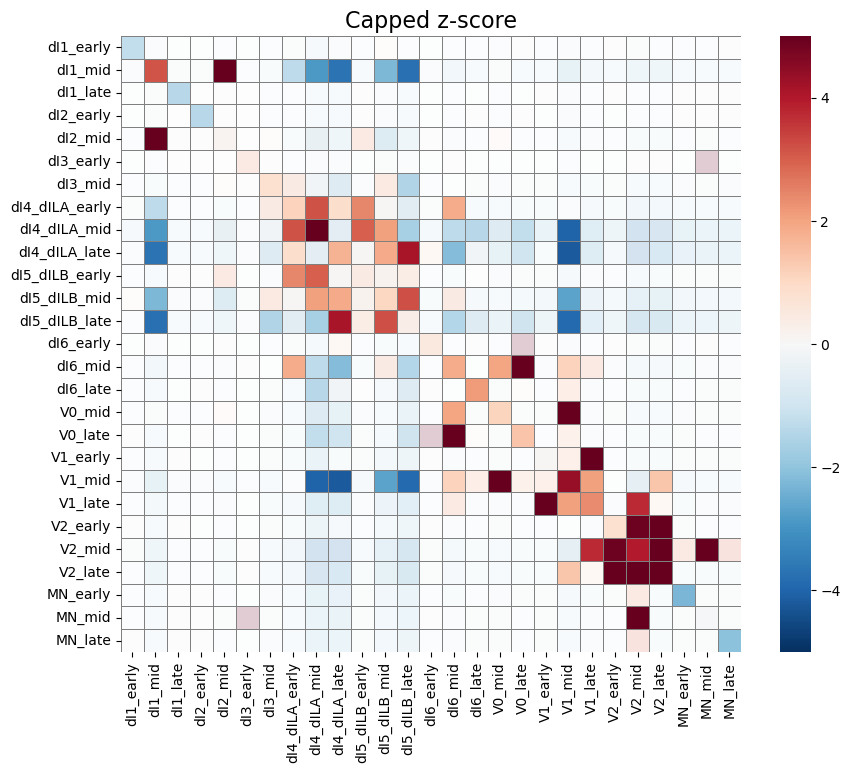

<Figure size 640x480 with 0 Axes>

In [63]:
#Fill the NA values
X = np.array(zscore_matrix.fillna(0))

plt.figure(figsize=(10, 8)) 

# Overlay heatmap for significant values with higher alpha
sns.heatmap(X, alpha=0.2, xticklabels = zscore_matrix.columns , yticklabels = zscore_matrix.columns , cmap='RdBu_r', vmin=-5, vmax=5, center=0, cbar = False)

# Overlay heatmap for significant values with higher alpha
sns.heatmap(X, alpha=1.0 , mask = mask, linewidths=0.5, linecolor='grey', xticklabels = zscore_matrix.columns , yticklabels = zscore_matrix.columns , cmap='RdBu_r', vmin=-5, vmax=5, center=0)

title_text = "Capped z-score"

# Set the title
plt.title(title_text, fontsize=16)

save_plot("zscore-all-waves-min2.pdf")

plt.show()
plt.clf()

###Correlation map 

✅ Plot saved to plots/waves/correlation-all-waves-min2.pdf.pdf


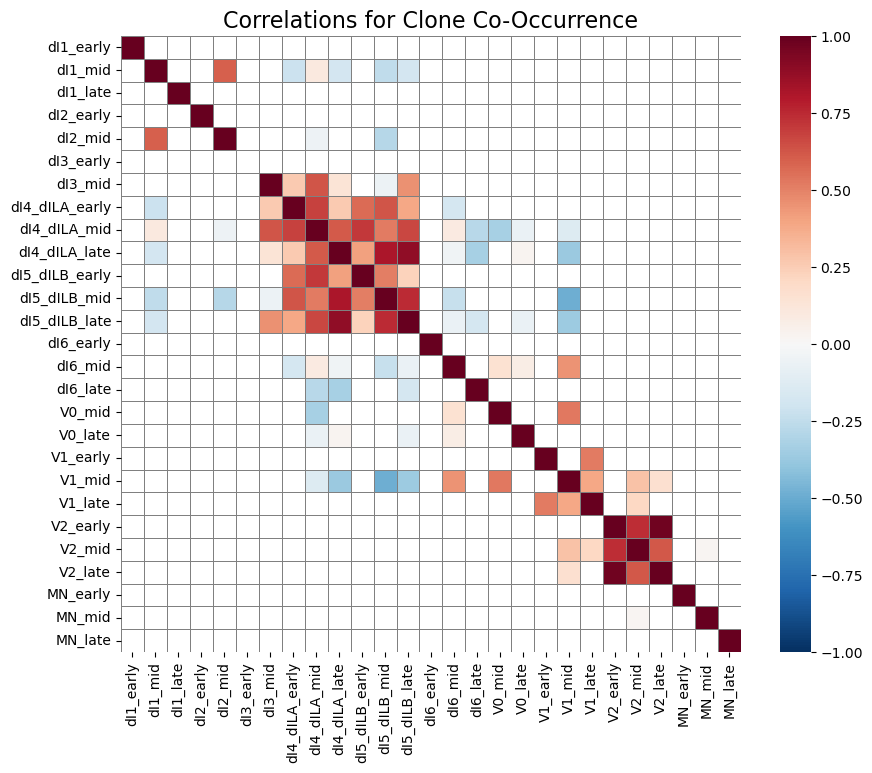

<Figure size 640x480 with 0 Axes>

In [64]:
# Ensure correlation matrix has no NaNs
X = np.array(lineag_coupling_corr.fillna(0))

# Make sure mask is aligned with correlation matrix
# (Assuming zscore_matrix and lineag_coupling_corr have the same indexing)
mask_corr = mask.copy()  # Copy to avoid accidental mutation

# Optional: double-check shapes match
assert X.shape == mask_corr.shape, "Mask shape doesn't match correlation matrix shape!"

plt.figure(figsize=(10, 8))
sns.heatmap(X, 
            mask=mask_corr, 
            linewidths=0.5, linecolor='grey',
            alpha=1.0, 
            xticklabels=zscore_matrix.columns, 
            yticklabels=zscore_matrix.columns,
            vmin=-1, vmax=1, cmap='RdBu_r', center=0)

plt.title("Correlations for Clone Co-Occurrence", fontsize=16)
save_plot("correlation-all-waves-min2.pdf")

plt.show()
plt.clf()

## Plot subsets

✅ Plot saved to plots/waves/zscore-MIDvsLATE-waves-min2.pdf.pdf


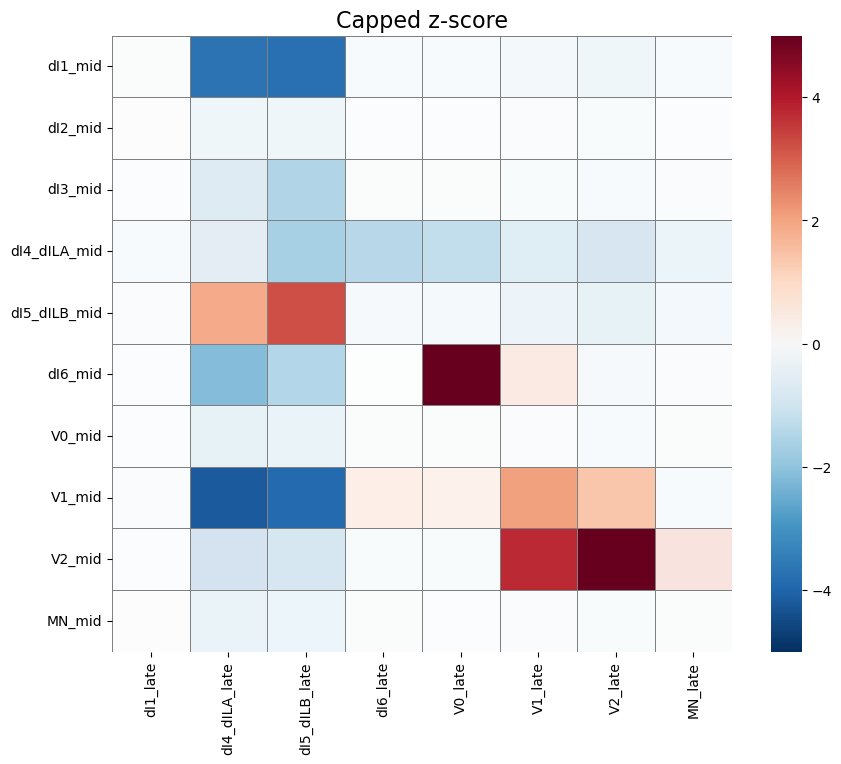

<Figure size 640x480 with 0 Axes>

In [65]:
#Which wave do you want on the y axis?
y_axis = "mid"
y_axis_boolean = [y_axis in el for el in zscore_matrix.columns]
y_axis_names = zscore_matrix.columns[y_axis_boolean]

#Which wave do you want on the x axis
x_axis = "late"
x_axis_boolean = [x_axis in el for el in zscore_matrix.columns]
x_axis_names = zscore_matrix.columns[x_axis_boolean]

#Fill the NA values
X = np.array(zscore_matrix.fillna(0))

X_sub = X[y_axis_boolean][:,x_axis_boolean]
mask_sub = mask[y_axis_boolean][:,x_axis_boolean]

plt.figure(figsize=(10, 8)) 

# Overlay heatmap for significant values with higher alpha
sns.heatmap(X_sub, alpha=0.2, xticklabels = x_axis_names , yticklabels = y_axis_names , cmap='RdBu_r', vmin=-5, vmax=5, center=0, cbar = False)

# Overlay heatmap for significant values with higher alpha
sns.heatmap(X_sub, alpha=1.0 , mask = mask_sub, linewidths=0.5, linecolor='grey', xticklabels = x_axis_names , yticklabels = y_axis_names , cmap='RdBu_r', vmin=-5, vmax=5, center=0)

title_text = "Capped z-score"

# Set the title
plt.title(title_text, fontsize=16)

save_plot("zscore-MIDvsLATE-waves-min2.pdf")
plt.show()
plt.clf()

✅ Plot saved to plots/waves/correlation-MIDvsLATE-waves-min2.pdf.pdf


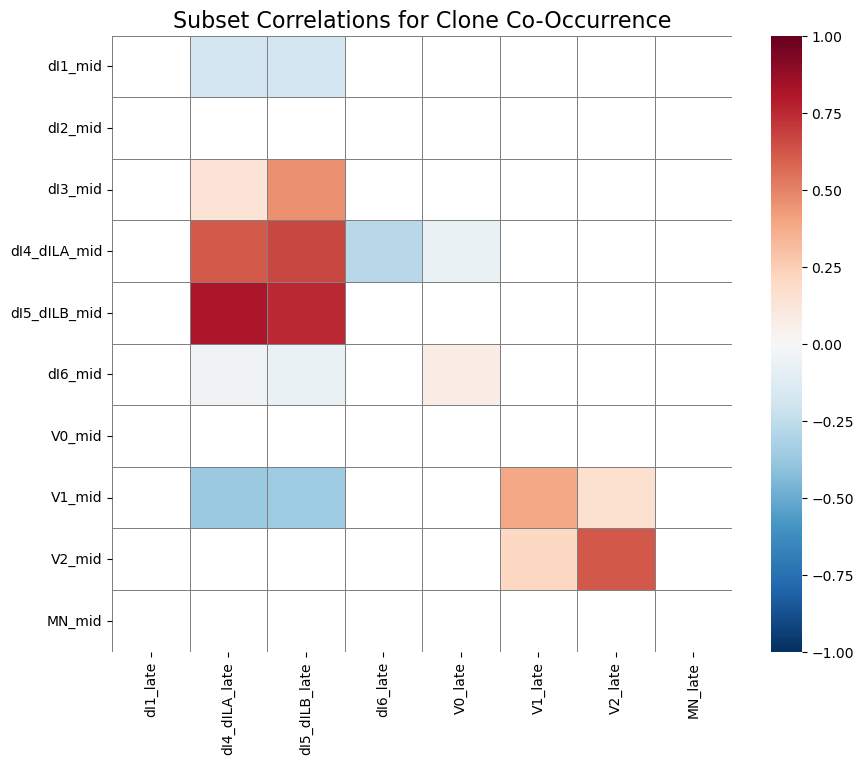

<Figure size 640x480 with 0 Axes>

In [66]:
# Which wave do you want on the y axis?
y_axis = "mid"
y_axis_boolean = [y_axis in el for el in lineag_coupling_corr.columns]
y_axis_names = lineag_coupling_corr.columns[y_axis_boolean]

# Which wave do you want on the x axis
x_axis = "late"
x_axis_boolean = [x_axis in el for el in lineag_coupling_corr.columns]
x_axis_names = lineag_coupling_corr.columns[x_axis_boolean]

# Fill the NA values
X_corr = np.array(lineag_coupling_corr.fillna(0))

# Subset matrix and mask
X_corr_sub = X_corr[y_axis_boolean][:, x_axis_boolean]
mask_sub = mask[y_axis_boolean][:, x_axis_boolean]

# Plot
plt.figure(figsize=(10, 8)) 
sns.heatmap(X_corr_sub, mask=mask_sub, xticklabels=x_axis_names, yticklabels=y_axis_names,
            cmap='RdBu_r', vmin=-1, vmax=1, center=0, linewidths=0.5, linecolor='grey')

plt.title("Subset Correlations for Clone Co-Occurrence", fontsize=16)

save_plot("correlation-MIDvsLATE-waves-min2.pdf")
plt.show()
plt.clf()